# Code clause
# Task No : 02
# Diabetic retinopathy detection

# Analysis of Class Labels (Diabetic Retinopathy Dataset)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Load labels csv file

def preprocess_labels_csv(filename="trainLabels.csv", new_column_names=['patient_id', 'eye']):
    labels = pd.read_csv(filename)
    labels["image"] = labels["image"].str.split("_")
    labels[new_column_names] = pd.DataFrame(labels["image"].values.tolist(), index= labels.index)
    return labels


# Plot class distribution as count or percentage

def plot_class_dist(labels, percentage=False):
    g = labels.groupby('level').count()['eye']
    
    y_label = "Count"
    x_label = "Class (severity of Diabetic Retinopathy)"
    
    if (percentage):    
        size = g.sum()
        g = 100*g/size
        y_label = "Percentage"
        
    p = g.plot(kind='bar', title="Distribution of class labels")
    p.set_ylabel(y_label)
    p.set_xlabel(x_label) 

# Class distribution as Counts

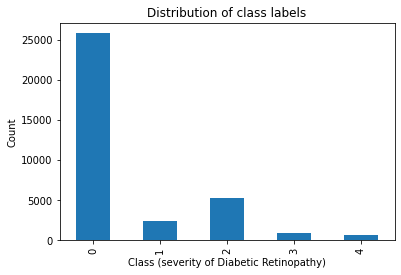

In [6]:
labels_df = preprocess_labels_csv()

plot_class_dist(labels_df)

# Class distribution as Percentage

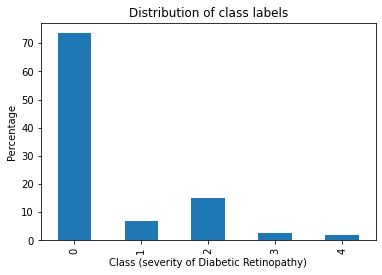

In [7]:
plot_class_dist(labels_df, True)

Analysis of Difference in Diagnosis of a subject with the condition for each eye
For each subject, two images along with their labels are provided (left and right eye). The following analysis show some summaries whether the two eyes have the same exact diagnosis or not.

In [8]:
# Read and rearrange data, add columns to facilicate plotting

def rearrange_labels(path="trainLabels.csv"):
    train_df = pd.read_csv("trainLabels.csv")
    train_df['image_path'] = train_df['image'] + '.jpeg'
    train_df['image'] = train_df['image'].str.split('_')
    df2 = pd.DataFrame(train_df['image'].values.tolist(), columns=['subject', 'eye'])
    
    new_labels_df = pd.concat([train_df, df2], axis=1).drop("image", axis=1) #modified
    new_labels_df=new_labels_df.reindex(train_df.index)
    g = new_labels_df.groupby('subject')
    df = g['level'].apply(list)

    new_df = pd.DataFrame(index=df.index)
    new_df['levels'] = df

    new_df = new_df.reset_index()
    final_df = pd.concat([pd.DataFrame(new_df.levels.tolist(), columns=["left", "right"]), new_df], axis=1) #join_axes=[new_df.index]
    final_df=final_df.reindex(new_df.index)
    
    final_df['eyes_equal'] = np.where(final_df['left'] == final_df['right'], 1, 0)
    final_df['eyes_diff_value'] = np.abs(final_df['right'] - final_df['left'])

    final_df['diagnosed_left'] = np.where(final_df.left >= 1, 1, 0)
    final_df['diagnosed_right'] = np.where(final_df.right >= 1, 1, 0)
    
    final_df['eyes_same_diagnosis'] = np.where(final_df['diagnosed_left'] == final_df['diagnosed_right'], 1, 0)
    
    return  final_df

In [9]:
eyes_labels_df = rearrange_labels()

# Plotting function
def display_plot(df, variable, x_label="", show_numbers=False, color="hotpink"):
    p = df.groupby(variable).count()['subject'].plot(kind='bar', color=color)
    p.set_ylabel("Count of Subjects")
    p.set_xlabel(x_label)
    if(show_numbers):
        for x in p.patches:
            p.annotate(str(int(x.get_height())), (x.get_x() + 0.1, x.get_height()*1.005))

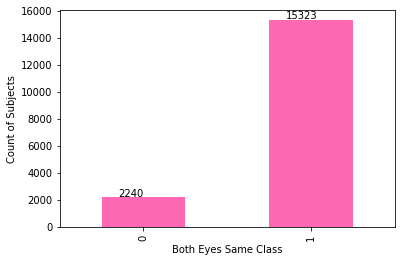

In [10]:
display_plot(eyes_labels_df, "eyes_equal", 
             x_label="Both Eyes Same Class", show_numbers=True)

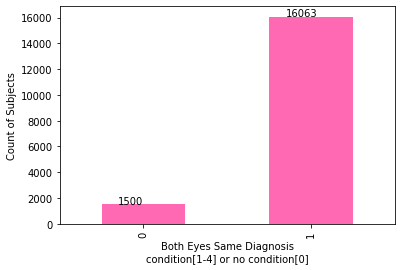

In [11]:
display_plot(eyes_labels_df, "eyes_same_diagnosis", 
             x_label="Both Eyes Same Diagnosis\ncondition[1-4] or no condition[0]", show_numbers=True)

# Absolute difference between the classes for both eyes of the subject
# **0 --> exact diagnosis**

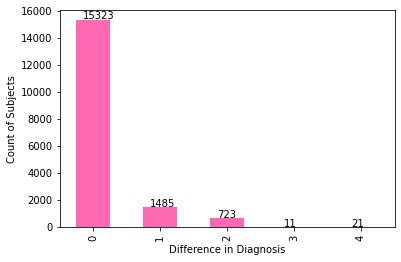

In [12]:
display_plot(eyes_labels_df, "eyes_diff_value", 
             x_label="Difference in Diagnosis", show_numbers=True)

In [13]:
import cv2, glob
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, exists
from os import listdir, makedirs
%matplotlib inline

In [37]:
def plot_images(images):
    plt.figure(figsize=(10, 10))
    columns = 2
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image.astype('uint8'))

In [15]:
def scaleRadius(img,scale):
    x=img[img.shape[0]//2,:,:].sum(1)
    r=(x>x.mean()/10).sum()/2
    s=scale*1.0/r
    return cv2.resize(img,(0,0),fx=s,fy=s)

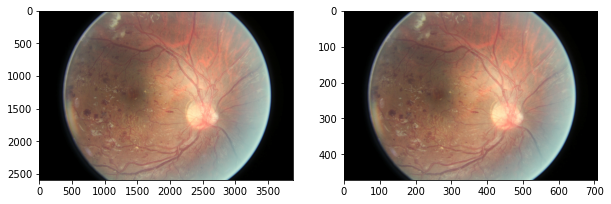

In [38]:
from google.colab.patches import cv2_imshow
# read_path = join('sample', '16_left.jpeg')
img = cv2.imread("16_left.jpeg", cv2.IMREAD_COLOR)
scale = 300
img2 = scaleRadius(img, scale)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plot_images([img,img2])

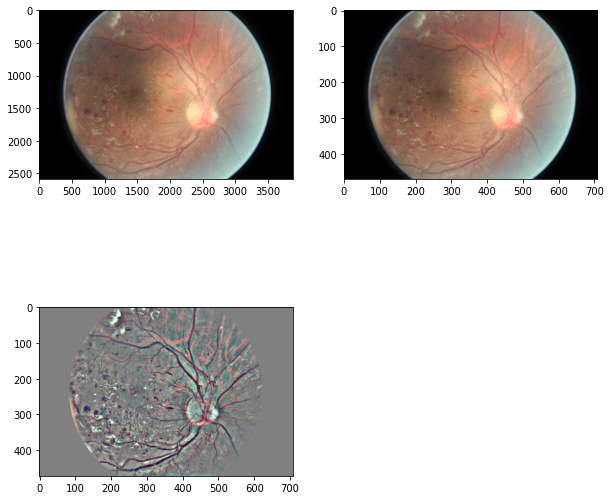

In [40]:
read_path = join('sample', '16_left.jpeg')

img = cv2.imread("16_left.jpeg", cv2.IMREAD_COLOR)
scale = 300
img2 = scaleRadius(img, scale)

b = np.zeros(img2.shape)
cv2.circle(b,(img2.shape[1]//2,img2.shape[0]//2),int(scale*0.9),(1,1,1),-1,8,0)
img3 = cv2.addWeighted(img2,4,cv2.GaussianBlur(img2,(0,0),scale/30),-4,128)*b+128*(1-b)



img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(np.float32(img3), cv2.COLOR_BGR2RGB)
plot_images([img, img2, img3])

In [42]:
def preprocess(folder='sample', scales=[300], save_path_same=True, target_size=(0,0)):
        
    for scale in scales:
        if (save_path_same):
            write_folder = folder+'_'+str(scale)
        else:
            write_folder = 'processed_'+str(scale)
        
        if not exists(write_folder):
            makedirs(write_folder)
            
        for f in listdir(folder):
            try:
                read_path = join(folder, f)
                a = cv2.imread(read_path)
                a = scaleRadius(a,scale)
                b = np.zeros(a.shape)
                cv2.circle(b,(a.shape[1]//2,a.shape[0]//2),int(scale*0.9),(1,1,1),-1,8,0)
                aa = cv2.addWeighted(a,4,cv2.GaussianBlur(a,(0,0),scale/30),-4,128)*b+128*(1-b)
                if (target_size != (0,0)):
                    aa = cv2.resize(aa, target_size)
                boo = cv2.imwrite(join(write_folder, f), aa)

                print("Processed Image: ", f)
                print("Save Location: ", join(write_folder, f))
                print("Success: ", boo)
                print("New Dimensions: ", aa.shape[0], " X ", aa.shape[1])
                print("______________________________________________\n")
                
            except:
                print("Could not process file: ", f)

In [45]:
preprocess('/content/drive/MyDrive/sample')

Processed Image:  13_right.jpeg
Save Location:  /content/drive/MyDrive/sample_300/13_right.jpeg
Success:  True
New Dimensions:  575  X  767
______________________________________________

Processed Image:  15_right.jpeg
Save Location:  /content/drive/MyDrive/sample_300/15_right.jpeg
Success:  True
New Dimensions:  614  X  927
______________________________________________

Processed Image:  15_left.jpeg
Save Location:  /content/drive/MyDrive/sample_300/15_left.jpeg
Success:  True
New Dimensions:  614  X  927
______________________________________________

Processed Image:  17_right.jpeg
Save Location:  /content/drive/MyDrive/sample_300/17_right.jpeg
Success:  True
New Dimensions:  630  X  945
______________________________________________

Processed Image:  17_left.jpeg
Save Location:  /content/drive/MyDrive/sample_300/17_left.jpeg
Success:  True
New Dimensions:  630  X  945
______________________________________________

Processed Image:  16_right.jpeg
Save Location:  /content/drive/M

In [46]:
import PIL
from PIL import Image
import random
from math import tan
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# partially from https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell

def plot_images(images):
    plt.figure(figsize=(10, 10))
    columns = 2
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

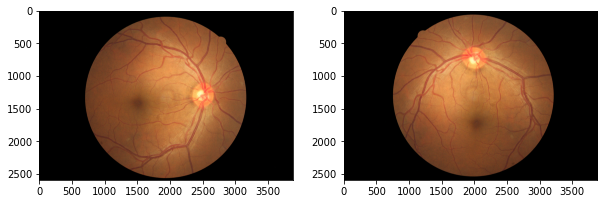

In [49]:
# Rotation Transform
Rotation = lambda x: x.rotate(random.uniform(0,360))

read_path = '/content/drive/MyDrive/sample/17_right.jpeg'
img1 = PIL.Image.open(read_path)


img2 = PIL.Image.open(read_path)
img2 = Rotation(img2)
plot_images([img1, img2])

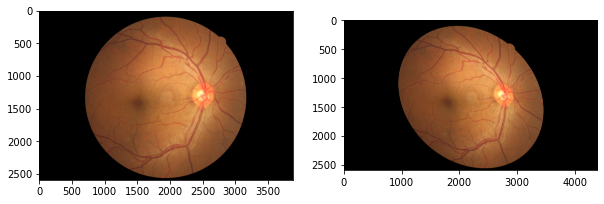

In [50]:
# Skew Transform

Skew = lambda x: skew_image(x, random.uniform(-0.2, 0.2), inc_width=True)
def skew_image(img, angle, inc_width=False):
    """
    Skew image using some math
    :param img: PIL image object
    :param angle: Angle in radians (function doesn't do well outside the range -1 -> 1, but still works)
    :return: PIL image object
    """
    width, height = img.size
    # Get the width that is to be added to the image based on the angle of skew
    xshift = tan(abs(angle)) * height
    new_width = width + int(xshift)

    if new_width < 0:
        return img

    # Apply transform
    img = img.transform(
        (new_width, height),
        Image.AFFINE,
        (1, angle, -xshift if angle > 0 else 0, 0, 1, 0),
        Image.BICUBIC
    )
    
    if (inc_width):
        return img
    else:
        return img.crop((0, 0, width, height))



read_path = '/content/drive/MyDrive/sample/17_right.jpeg'
img1 = PIL.Image.open(read_path)


img2 = PIL.Image.open(read_path)
img2 = Skew(img2)

plot_images([img1, img2])

In [51]:
# imports
from math import tan
from PIL import Image

# Rotation Transform
Rotation = lambda x: x.rotate(random.uniform(0,360))

# Skew Transform
Skew = lambda x: skew_image(x, random.uniform(-0.2, 0.2), inc_width=True)


def skew_image(img, angle, inc_width=False):
    """
    Skew image using some math
    :param img: PIL image object
    :param angle: Angle in radians (function doesn't do well outside the range -1 -> 1, but still works)
    :return: PIL image object
    """
    width, height = img.size
    # Get the width that is to be added to the image based on the angle of skew
    xshift = tan(abs(angle)) * height
    new_width = width + int(xshift)

    if new_width < 0:
        return img

    # Apply transform
    img = img.transform(
        (new_width, height),
        Image.AFFINE,
        (1, angle, -xshift if angle > 0 else 0, 0, 1, 0),
        Image.BICUBIC
    )
    
    if (inc_width):
        return img
    else:
        return img.crop((0, 0, width, height))

# **Test Torch Data Loader Transforms**
# **Imports and functions needed**

In [52]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets.folder import default_loader
from torchvision import transforms
from random import uniform
import numpy as np
from PIL import Image
from math import tan
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


class RetinopathyDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None, loader=default_loader):
        self.root_dir = Path(root_dir) if type(root_dir) is str else root_dir
        self.image_names = list(self.root_dir.glob('*.jpeg'))
        self.transform = transform
        if csv_file:
            labels = pd.read_csv(csv_file)
            self.labels = dict(zip(list(labels.image), list(labels.level)))
        else:
            self.labels = None
        self.loader = loader

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_path = self.image_names[index]
        image = self.loader(image_path)
        if self.transform:
            image = self.transform(image)

        if self.labels:
            label = self.labels[image_path.stem]
            return image, label
        else:
            return image, image_path.stem


# customization of https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
def get_dataset(data_dir,
                           label_path,
                           batch_size,
                           train_transforms,
                           valid_transforms,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=False, get_dataset_objects=False):
    
    return RetinopathyDataset(data_dir, label_path, train_transforms)

# Function to implement skew based on PIL transform

def skew_image(img, angle, inc_width=False):
    """
    Skew image using some math
    :param img: PIL image object
    :param angle: Angle in radians (function doesn't do well outside the range -1 -> 1, but still works)
    :return: PIL image object
    """
    width, height = img.size
    # Get the width that is to be added to the image based on the angle of skew
    xshift = tan(abs(angle)) * height
    new_width = width + int(xshift)

    if new_width < 0:
        return img

    # Apply transform
    img = img.transform(
        (new_width, height),
        Image.AFFINE,
        (1, angle, -xshift if angle > 0 else 0, 0, 1, 0),
        Image.BICUBIC
    )
    
    if (inc_width):
        return img
    else:
        return img.crop((0, 0, width, height))
    

def plot_images(images):
    plt.figure(figsize=(10, 10))
    columns = 2
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

In [53]:
train_data_transforms = transforms.Compose([
    
    transforms.Lambda(lambda x: x.rotate(uniform(0,360), resample=Image.BICUBIC)),  # random rotation 0 to 360
    transforms.Lambda(lambda x: skew_image(x, uniform(-0.2, 0.2), inc_width=True)), # random skew +- 0.2
    transforms.RandomResizedCrop(300, scale=(0.9, 1.1), ratio=(1,1)),               # scale +- 10%, resize to 300
    transforms.CenterCrop((224))                                                    # take 224x224 center crop
    #transforms.ToTensor() # commented to get the images as PIL Image object
])

In [61]:
data_params = {
    'train_path': '../data/train_300',
    'test_path': '../data/test',
    'label_path': 'trainLabels.csv',
    'batch_size': 1,
    'submission_file': 'submission.csv'
}

# **Conclusion** : DR is a critical medical health disorder causing blindness which is of utmost concern, and DL techniques can have an effective role ...